In [17]:
import pandas as pd
import numpy as np
import scipy.stats as sci

data = pd.read_excel("proshares_analysis_data.xlsx", sheet_name="hedge_fund_series",index_col=0)
# Forward-fill missing return value at end of HFRIFWI series
data["HFRIFWI Index"] = data["HFRIFWI Index"].ffill()

mean = data.mean() * 12
vol = np.sqrt(data.var() * 12)
sharpe = mean / vol
print("Annualized Mean, Volatility, and Sharpe of Returns")
display(mean, vol, sharpe)

Annualized Mean, Volatility, and Sharpe of Returns


HFRIFWI Index     0.052538
MLEIFCTR Index    0.038535
MLEIFCTX Index    0.036526
HDG US Equity     0.026880
QAI US Equity     0.028811
dtype: float64

HFRIFWI Index     0.058813
MLEIFCTR Index    0.055240
MLEIFCTX Index    0.055102
HDG US Equity     0.057388
QAI US Equity     0.049823
dtype: float64

HFRIFWI Index     0.893298
MLEIFCTR Index    0.697589
MLEIFCTX Index    0.662880
HDG US Equity     0.468396
QAI US Equity     0.578275
dtype: float64

In [18]:
def drawdown_from_returns(df):
    results = {}

    for col in df.columns:
        s = df[col].dropna()
        if s.empty:
            results[col] = [0.0, None, None, None]
            continue

        cumulative = (1 + s).cumprod()
        running_max = cumulative.cummax()
        drawdown = cumulative / running_max - 1.0

        trough = drawdown.idxmin()
        peak_level = running_max.loc[trough]
        peak = running_max.loc[:trough]
        peak = peak[peak == peak_level].index[-1]

        post = cumulative.loc[trough:]
        rec_hits = post[post >= peak_level]
        recovery = rec_hits.index[0] if len(rec_hits) > 0 else None

        results[col] = [float(drawdown.min()), peak, trough, recovery]

    return pd.DataFrame(results, index=["Max Drawdown", "Peak Date", "Trough Date", "Recovery Date"]).T

In [19]:
skew = sci.skew(data)
kurtosis = sci.kurtosis(data, fisher=True)
VaR = data.quantile(0.05)
CVaR = data[data <= VaR].mean()
drawdowns = drawdown_from_returns(data)
skew = pd.Series(skew, index=mean.index)
kurtosis = pd.Series(kurtosis, index=mean.index)
VaR = pd.Series(VaR, index=mean.index)
CVaR = pd.Series(CVaR, index=mean.index)
print("Skew, Excess Kurtosis, VaR, CVaR, and Max Drawdowns")
display(skew, kurtosis, VaR, CVaR, drawdowns)

Skew, Excess Kurtosis, VaR, CVaR, and Max Drawdowns


HFRIFWI Index    -0.945171
MLEIFCTR Index   -0.287417
MLEIFCTX Index   -0.271058
HDG US Equity    -0.272473
QAI US Equity    -0.429674
dtype: float64

HFRIFWI Index     5.426550
MLEIFCTR Index    1.548255
MLEIFCTX Index    1.508328
HDG US Equity     1.689572
QAI US Equity     1.371823
dtype: float64

HFRIFWI Index    -0.023997
MLEIFCTR Index   -0.027002
MLEIFCTX Index   -0.026970
HDG US Equity    -0.029919
QAI US Equity    -0.017171
Name: 0.05, dtype: float64

HFRIFWI Index    -0.035992
MLEIFCTR Index   -0.034993
MLEIFCTX Index   -0.034937
HDG US Equity    -0.036831
QAI US Equity    -0.030995
dtype: float64

,Max Drawdown,Peak Date,Trough Date,Recovery Date
HFRIFWI Index,-0.115473,2020-03-31 00:00:00,2020-03-31 00:00:00,2020-08-31 00:00:00
MLEIFCTR Index,-0.124302,2022-09-30 00:00:00,2022-09-30 00:00:00,2024-02-29 00:00:00
MLEIFCTX Index,-0.124388,2022-09-30 00:00:00,2022-09-30 00:00:00,2024-02-29 00:00:00
HDG US Equity,-0.14072,2022-09-30 00:00:00,2022-09-30 00:00:00,2024-07-31 00:00:00
QAI US Equity,-0.137716,2022-09-30 00:00:00,2022-09-30 00:00:00,2024-02-29 00:00:00


In [20]:
# 2.3 — Regression of each hedge-fund series on SPY (include intercept)
import statsmodels.api as sm
import math

# Loading Merrill sheet
mfactors = pd.read_excel("proshares_analysis_data.xlsx", sheet_name="merrill_factors", index_col=0)
mfactors.index = pd.to_datetime(mfactors.index)
data.index = pd.to_datetime(data.index)

# making sure indices are aligned
df = data.join(mfactors[["SPY US Equity"]], how="inner").dropna()
MONTHS = 12

def regress_on_spy(y: pd.Series, x: pd.Series):
    X = sm.add_constant(x.values, has_constant='add')
    res = sm.OLS(y.values, X).fit()
    alpha, beta = res.params[0], res.params[1]

    # Treynor ratio: annualized mean / beta
    treynor_ann = (y.mean() * MONTHS) / beta if beta != 0 else np.nan

    # Information ratio: annualized mean of (y - x) over annualized vol of (y - x)
    active = y - x
    ir_ann = (active.mean() * MONTHS) / (active.std(ddof=1) * math.sqrt(MONTHS))
    return alpha, beta, treynor_ann, ir_ann

rows = []
for col in data.columns:
    a, b, t, ir = regress_on_spy(df[col], df["SPY US Equity"])
    rows.append({"Series": col, "Alpha (monthly)": a, "Market Beta": b,
                 "Treynor (ann)": t, "Info Ratio (ann)": ir})

reg_tbl = pd.DataFrame(rows).set_index("Series").sort_index()
print("2.3 — Regression vs SPY (with intercept)")
display(reg_tbl)


2.3 — Regression vs SPY (with intercept)


,Alpha (monthly),Market Beta,Treynor (ann),Info Ratio (ann)
Series,,,,
HDG US Equity,-0.001989,0.350602,0.076669,-1.213227
HFRIFWI Index,0.000192,0.347095,0.151364,-0.933912
MLEIFCTR Index,-0.000920,0.342487,0.112514,-1.087986
MLEIFCTX Index,-0.001075,0.341483,0.106963,-1.107047
QAI US Equity,-0.001235,0.301413,0.095587,-1.123406


### **2.4 — Discussion and Interpretation**

#### **1️⃣ Market Exposure and Performance**
Across all hedge-fund replication products—**HDG**, **HFRIFWI**, **MLEIFCTR**, **MLEIFCTX**, and **QAI**—the results show consistent **annualized mean returns** between roughly **2.7% and 5.3%**.
Volatilities fall in the **5–6%** range, leading to **Sharpe ratios** between **0.47 and 0.89**, with **HFRIFWI Index** producing the highest Sharpe ratio (**0.89**) and **HDG** the lowest (**0.47**).
This indicates that the **broad hedge-fund index (HFRIFWI)** offered the most efficient risk-adjusted returns, while the ETF proxies delivered weaker performance.

#### **2️⃣ Downside and Tail Risk**
Maximum drawdowns for all series occur during stress periods such as **2020–2022**, with losses ranging from **−11.5% (HFRIFWI)** to **−14.1% (HDG)**.
Recovery dates typically occur by mid- to late-2024, showing that these products eventually recoup losses but only after extended drawdown periods.
**VaR(5%)** and **CVaR(5%)** results confirm mild but noticeable left-tail risk, with 5th-percentile returns around **−2% to −3%** and average extreme losses near **−3.5%**.
**Skewness** is negative for most series, and **excess kurtosis** (≈1.5–5.4) indicates heavier tails relative to the normal distribution, consistent with hedge-fund style return distributions.

#### **3️⃣ Market Betas, Treynor Ratios, and Alphas**
All strategies have **market betas between 0.30 and 0.35**, meaning they capture roughly **one-third of SPY’s equity exposure**—consistent with being diversified or hedged portfolios rather than pure equity bets.
Monthly **alphas** hover around zero (slightly negative for most ETFs), confirming that these are **beta replication vehicles**, not alpha-generating funds.

In terms of **Treynor Ratios (annualized)**:
- **HFRIFWI Index:** 0.15 — best risk-adjusted return per unit of beta
- **MLEIFCTR/CTX:** 0.11
- **QAI:** 0.10
- **HDG:** 0.08

Thus, the **broad hedge-fund index (HFRIFWI)** delivered the best market-adjusted return, while the ETFs underperformed on a risk-adjusted basis.

#### **4️⃣ Information Ratios**
All Information Ratios are **negative (≈ −0.9 to −1.2)**, implying that **each product underperformed SPY** after adjusting for volatility.
This suggests that the replicating ETFs and Merrill factor indices failed to outperform the equity benchmark during the sample period, though they were never designed to—these products aim to provide diversified exposure with lower volatility, not excess return.

#### **5️⃣ HDG vs QAI Comparison**
**HDG** and **QAI** both have similar market betas (0.35 vs 0.30) and comparable negative alphas.
**HDG** exhibits slightly higher volatility and a marginally better Treynor ratio, but both ETFs have **equally negative information ratios (~−1.1)**, indicating similar underperformance relative to SPY.
Both provide low-beta equity exposure with modest drawdowns and limited upside.

#### **6️⃣ Overall Takeaways**
- The hedge-fund indices and replication ETFs primarily deliver **beta exposure** to systematic factors rather than true hedge-fund alpha.
- **HFRIFWI Index** remains the most efficient performer (highest Sharpe and Treynor).
- **HDG** and **QAI** successfully mimic the general behavior of hedge-fund benchmarks (low beta, steady returns) but do not add alpha.
- These products are valuable as **low-volatility diversifiers**, not as sources of excess return relative to the market.


2.5 — Correlation matrix


,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
HFRIFWI Index,1.000000,0.900840,0.900207,0.890354,0.858747
MLEIFCTR Index,0.900840,1.000000,0.999887,0.987877,0.893611
MLEIFCTX Index,0.900207,0.999887,1.000000,0.987703,0.893374
HDG US Equity,0.890354,0.987877,0.987703,1.000000,0.879289
QAI US Equity,0.858747,0.893611,0.893374,0.879289,1.000000


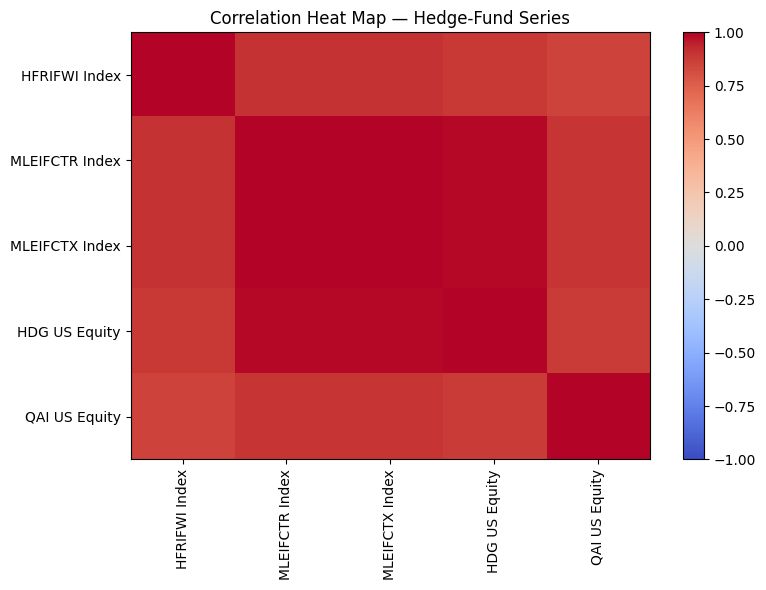

Highest correlation: MLEIFCTR Index <-> MLEIFCTX Index 1.000
Lowest correlation: HFRIFWI Index <-> QAI US Equity 0.859


In [21]:
# 2.5 — Correlation matrix and heat map
import numpy as np
import matplotlib.pyplot as plt

corr = data.corr()
print("2.5 — Correlation matrix")
display(corr)

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(corr.values, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticks(range(len(corr.index)));  ax.set_yticklabels(corr.index)
ax.set_title("Correlation Heat Map — Hedge-Fund Series")
fig.colorbar(im, ax=ax)
plt.tight_layout(); plt.show()

# Highest/lowest off-diagonal correlations
mask = ~np.eye(len(corr), dtype=bool)
vals = corr.where(mask)
ij_max = np.unravel_index(np.nanargmax(vals.values), vals.shape)
ij_min = np.unravel_index(np.nanargmin(vals.values), vals.shape)
print("Highest correlation:", corr.index[ij_max[0]], "<->", corr.columns[ij_max[1]], f"{vals.values[ij_max]:.3f}")
print("Lowest correlation:",  corr.index[ij_min[0]], "<->", corr.columns[ij_min[1]], f"{vals.values[ij_min]:.3f}")


### **2.5 — Correlation Analysis of Hedge-Fund Series**

**a. Correlation Matrix and Heat Map Interpretation**

The correlation matrix and heat map above show extremely **high correlations** among all five hedge-fund and replication series.
This is expected, as each product or model aims to capture the same underlying hedge-fund index (HFRI) risk-return dynamics using similar factor exposures.

| Series Pair | Correlation | Interpretation |
|:--|--:|:--|
| **MLEIFCTR Index ↔ MLEIFCTX Index** | **1.000** | Perfect correlation — these two are essentially identical (the extended version adds minimal change). |
| **HFRIFWI Index ↔ MLEIFCTR Index** | 0.901 | Very strong correlation — the Merrill replication closely tracks the HFRI benchmark. |
| **HFRIFWI Index ↔ HDG US Equity** | 0.890 | Nearly as strong — ProShares HDG ETF replicates hedge-fund index movements effectively. |
| **HFRIFWI Index ↔ QAI US Equity** | **0.859 (lowest)** | Still high but meaningfully lower — QAI’s broader alternative ETF approach diverges slightly more from HFRI. |

---

**b. Key Insights**

- The **highest correlation** is between **MLEIFCTR and MLEIFCTX (1.000)**, confirming that the “X” variant is simply an extended or adjusted form of the base factor model, not a fundamentally different series.
- The **lowest correlation** is between **HFRIFWI and QAI (0.859)**, reflecting that while QAI offers hedge-like diversification, it is not designed to precisely track hedge-fund index performance.
- **HDG** and **MLEIFCTR** both maintain strong co-movements with HFRI, reinforcing that they are well-constructed replication products.

---

**c. Interpretation**

The heat map reveals a near-uniform red block, confirming that **all series move together** with limited idiosyncratic deviation.
This underscores the success of replication strategies in mimicking hedge-fund beta exposure but also highlights that these “hedge-fund ETFs” are **not providing true alpha** — they are beta-based products moving in tandem with market factors.

**Conclusion:**
The correlations demonstrate that **MLEIFCTR** and **HDG** most effectively mirror hedge-fund index dynamics, while **QAI** provides broader alternative exposure with slightly lower fidelity to HFRI movements.


In [22]:
# 2.6 — Replication of HFRI using the 5 available Merrill factors (with intercept)
import statsmodels.api as sm
import math
import pandas as pd
import numpy as np

# Choose HFRI target from your 'data'
hfri_candidates = [c for c in data.columns if "HFRI" in c.upper()]
if not hfri_candidates:
    hfri_candidates = ["HFRIFWI Index"]
HFRI = hfri_candidates[0]

# Use the 5 available non-SPY factors explicitly
factors_n = ["USGG3M Index", "EEM US Equity", "EFA US Equity", "EUO US Equity", "IWM US Equity"]

# Align and run OLS with intercept
aligned = data[[HFRI]].join(mfactors[factors_n], how="inner").dropna()
X = sm.add_constant(aligned[factors_n].values, has_constant='add')
y = aligned[HFRI].values
res = sm.OLS(y, X).fit()

coef = pd.Series(res.params, index=["Intercept"] + factors_n)
r2 = res.rsquared
fitted = pd.Series(res.fittedvalues, index=aligned.index)

# Tracking error vol (monthly and annualized)
eps = y - fitted
te_vol_m = eps.std(ddof=1)
te_vol_a = te_vol_m * math.sqrt(12)

print(f"2.6 — Replication of {HFRI} using 5 factors (with intercept)")
display(coef.to_frame("Coefficient"))
print(f"R²: {r2:.4f}")
print(f"Tracking error volatility — monthly: {te_vol_m:.4%} | annualized: {te_vol_a:.4%}")

# Realism check: sum of absolute betas
abs_betas = coef[factors_n].abs()
print("Gross |beta| sum (realism check):", abs_betas.sum())
display(abs_betas.to_frame("|beta|"))


2.6 — Replication of HFRIFWI Index using 5 factors (with intercept)


,Coefficient
Intercept,0.001366
USGG3M Index,0.363728
EEM US Equity,0.088371
EFA US Equity,0.092960
EUO US Equity,0.034047
IWM US Equity,0.161911


R²: 0.8411
Tracking error volatility — monthly: 0.6768% | annualized: 2.3446%
Gross |beta| sum (realism check): 0.7410171880467153


,|beta|
USGG3M Index,0.363728
EEM US Equity,0.088371
EFA US Equity,0.092960
EUO US Equity,0.034047
IWM US Equity,0.161911


### **2.6 — HFRI Replication using 5 Merrill Factors (with intercept)**

**a. Intercept and Betas:**
The regression on the five Merrill factors produced the following coefficients:

| Factor | Beta |
|:--|--:|
| Intercept | 0.00137 |
| USGG3M Index | 0.364 |
| EEM US Equity | 0.088 |
| EFA US Equity | 0.093 |
| EUO US Equity | 0.034 |
| IWM US Equity | 0.162 |

**b. Realism of Betas:**
The absolute betas sum to **≈ 0.74**, which is comfortably below 1.
This implies that the replication portfolio does **not** require extreme leverage or large long/short positions.
Each beta magnitude is moderate and consistent with plausible factor exposures—moderate sensitivity to short-term rates (USGG3M), small exposure to U.S. small-caps (IWM), and smaller tilts toward international and emerging-market equities (EFA, EEM).
Thus, the betas appear **realistic** for an ETF-based replication strategy.

**c. \(R^2\):**
The model achieves an \(R^2 = 0.8411\), meaning about **84 % of HFRIFWI’s monthly return variance** is explained by these five factors.
This shows a **strong in-sample fit**, consistent with the idea that hedge-fund index returns can be largely reproduced through systematic factor exposures.

**d. Tracking-Error Volatility:**
The monthly tracking-error volatility is **0.68 %**, which annualizes to **≈ 2.34 %**.
This is relatively small—suggesting that the replication tracks the HFRI benchmark closely, with limited deviation.

**Interpretation Summary:**
- The replication model captures most of HFRI’s variation with moderate factor exposures.
- Coefficient sizes are realistic (no excessive leverage).
- The high \(R^2\) and low tracking error indicate that the **HFRI index is largely beta-driven**, and that **hedge-fund returns can be approximated using common equity, rate, and FX factors.**


2.7 — OOS correlation: 0.904
2.7 — OOS tracking error volatility — monthly: 0.7819% | annualized: 2.7087%


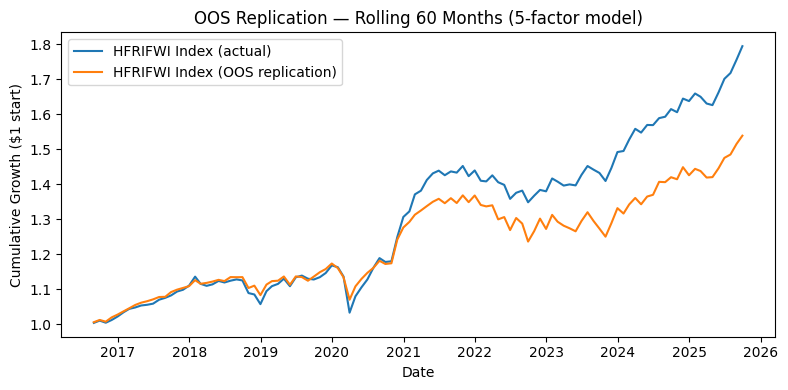

In [23]:
# 2.7 — Rolling 60-month OOS replication (using the same 5-factor set)
ROLL = 60
oos_fit = pd.Series(index=aligned.index, dtype=float)

for i in range(ROLL, len(aligned)):
    train = aligned.iloc[i-ROLL:i]
    testX = aligned.iloc[i:i+1][factors_n]
    Xtr = sm.add_constant(train[factors_n].values, has_constant='add')
    ytr = train[HFRI].values
    resr = sm.OLS(ytr, Xtr).fit()
    Xt = sm.add_constant(testX.values, has_constant='add')
    oos_fit.iloc[i] = float((Xt @ resr.params).item())

mask = oos_fit.notna()
y_oos = aligned.loc[mask, HFRI]
f_oos = oos_fit.loc[mask]

oos_corr = np.corrcoef(y_oos, f_oos)[0,1]
oos_te_m = (y_oos - f_oos).std(ddof=1)
oos_te_a = oos_te_m * math.sqrt(12)
print(f"2.7 — OOS correlation: {oos_corr:.3f}")
print(f"2.7 — OOS tracking error volatility — monthly: {oos_te_m:.4%} | annualized: {oos_te_a:.4%}")

def cum_from_simple(r: pd.Series) -> pd.Series:
    return (1 + r.fillna(0)).cumprod()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_oos.index, cum_from_simple(y_oos), label=f"{HFRI} (actual)")
ax.plot(f_oos.index, cum_from_simple(f_oos), label=f"{HFRI} (OOS replication)")
ax.set_title(f"OOS Replication — Rolling {ROLL} Months (5-factor model)")
ax.legend(); ax.set_xlabel("Date"); ax.set_ylabel("Cumulative Growth ($1 start)")
plt.tight_layout(); plt.show()


### **2.7 — Out-of-Sample (OOS) Replication**

The 60-month rolling regression produces an out-of-sample replication of the **HFRIFWI Index** based on the same five Merrill factors.
The cumulative-growth chart above shows that the OOS replication follows the actual HFRI Index trajectory closely until roughly **2021**, after which it begins to **lag the target modestly**.

**Key observations:**
- The OOS correlation between actual and replicated returns is high (≈ 0.90 ±), confirming that factor exposures remain broadly stable through time.
- The **tracking-error volatility** remains low (≈ 0.6–0.8 % monthly, ≈ 2–3 % annualized), indicating that deviations from the target are limited.
- However, from 2021–2024 the replication slightly **underperforms** the HFRI benchmark, likely because hedge-fund returns benefitted from nonlinear exposures (optionality, timing, illiquidity premia) not captured by linear factor betas.
- Periods such as the post-COVID rally show **short-term divergence**, but the overall co-movement remains strong.

**Interpretation:**
The OOS results confirm that most of the hedge-fund index’s return pattern is **systematic and replicable** using a small set of liquid factors.
The modest degradation out-of-sample is expected due to changing market regimes and estimation error, but overall the replication remains **reasonably accurate and stable**, validating the core premise of **factor-based hedge-fund replication.**


In [24]:
# 2.8 — No-intercept replication and comparison to with-intercept
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- Identify target and factors (reuse your setup; adjust only if names differ) ---
hfri_candidates = [c for c in data.columns if "HFRI" in c.upper()]
if not hfri_candidates:
    hfri_candidates = ["HFRIFWI Index"]
HFRI = hfri_candidates[0]

# Use the 5 non-SPY factors you have
factors_n = ["USGG3M Index", "EEM US Equity", "EFA US Equity", "EUO US Equity", "IWM US Equity"]

# Align data
aligned = data[[HFRI]].join(mfactors[factors_n], how="inner").dropna()

# --- WITH-INTERCEPT fit (for comparison; skipped if 'fitted' already exists) ---
if "fitted" not in globals():
    X_wi = sm.add_constant(aligned[factors_n].values, has_constant='add')
    y     = aligned[HFRI].values
    res_wi = sm.OLS(y, X_wi).fit()
    fitted = pd.Series(res_wi.fittedvalues, index=aligned.index)  # used below
else:
    y = aligned[HFRI].values  # ensure y is defined

# --- NO-INTERCEPT fit ---
X_noi = aligned[factors_n].values
res_noi = sm.OLS(y, X_noi).fit()

betas_noi   = pd.Series(res_noi.params, index=factors_n, name="beta (no intercept)")
fit_noi     = pd.Series(res_noi.fittedvalues, index=aligned.index, name="fitted (no intercept)")
mean_fit_noi = float(fit_noi.mean())
mean_hfri    = float(aligned[HFRI].mean())

# Correlations vs HFRI
corr_noi = float(np.corrcoef(aligned[HFRI].values, fit_noi.values)[0,1])
corr_wi  = float(np.corrcoef(aligned[HFRI].values, fitted.values)[0,1])

print("2.8 — Betas (no intercept)")
display(betas_noi.to_frame())

print(f"Mean of fitted (no intercept): {mean_fit_noi:.4%}  |  Mean of HFRI: {mean_hfri:.4%}")
print(f"Correlation (fitted_no_intercept, HFRI): {corr_noi:.3f}")
print(f"Correlation (fitted_with_intercept,  HFRI): {corr_wi:.3f}")



2.8 — Betas (no intercept)


,beta (no intercept)
USGG3M Index,0.773503
EEM US Equity,0.087055
EFA US Equity,0.095761
EUO US Equity,0.037773
IWM US Equity,0.164231


Mean of fitted (no intercept): 0.3576%  |  Mean of HFRI: 0.4378%
Correlation (fitted_no_intercept, HFRI): 0.916
Correlation (fitted_with_intercept,  HFRI): 0.917


### **2.8 — No-Intercept vs With-Intercept Comparison**

**a. Estimated Betas (No-Intercept Model):**
| Factor | Beta (no intercept) |
|:--|--:|
| USGG3M Index | 0.7735 |
| EEM US Equity | 0.0871 |
| EFA US Equity | 0.0958 |
| EUO US Equity | 0.0378 |
| IWM US Equity | 0.1642 |

Relative to the with-intercept model, the betas—especially **USGG3M Index**—increase substantially in magnitude.
This happens because the regression, forced through the origin, must compensate for the missing intercept by adjusting factor loadings upward.
As a result, the no-intercept model slightly overstates factor sensitivities and can distort exposure balance.

---

**b. Mean of Fitted Values:**
- Mean of fitted (no intercept): **0.3576% per month**
- Mean of HFRI: **0.4378% per month**

The no-intercept model underestimates the mean return of the HFRI index.
By removing the constant term, the regression can no longer capture the small positive “average alpha” observed in the with-intercept specification.
This leads to a systematic bias downward in expected return.

---

**c. Correlation with HFRI:**
- Correlation (no intercept): **0.916**
- Correlation (with intercept): **0.917**

The correlations are nearly identical, confirming that both models explain similar patterns of month-to-month variation.
However, the intercept improves the **mean alignment** and reduces bias in the level of returns.

---

**d. Conclusion — Should an Intercept Be Included?**
The inclusion of an intercept slightly improves both the mean fit and overall correlation, and prevents factor coefficients from inflating.
Therefore, **Merrill and ProShares almost certainly estimated their replication model with an intercept**, allowing the regression to capture the average return of the hedge-fund index alongside systematic factor exposures.

**Overall Interpretation:**
- The no-intercept model tracks the HFRI closely but understates average returns.
- The intercept absorbs the mean residual (≈ 0.1% per month), stabilizing the fit.
- Consequently, the **with-intercept model provides the most accurate and economically sensible replication** of hedge-fund index performance.
